## Import the required libraries

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Import and prepare training data

In [22]:
filenames = os.listdir("data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [23]:
df.head()

filename  category
0   dog.8011.jpg         1
1   cat.5077.jpg         0
2   dog.7322.jpg         1
3   cat.2718.jpg         0
4  cat.10151.jpg         0

In [24]:
df['category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 25000 entries, 0 to 24999
Series name: category
Non-Null Count  Dtype
--------------  -----
25000 non-null  int64
dtypes: int64(1)
memory usage: 195.4 KB


<AxesSubplot:>

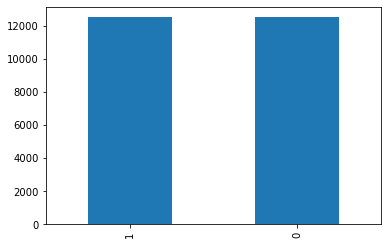

In [25]:
df['category'].value_counts().plot.bar()

We can see that the total amount of dog and cat images are equal.

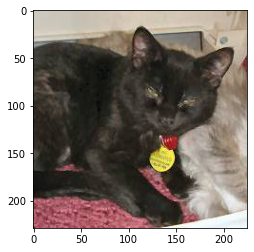

In [26]:
sample = random.choice(filenames)
image = load_img("data/train/"+sample)
plt.imshow(image)

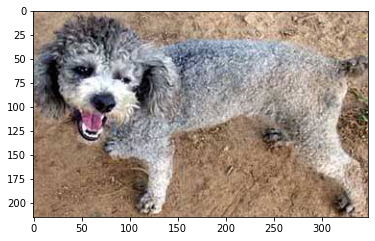

In [27]:
sample = random.choice(filenames)
image = load_img("data/train/"+sample)
plt.imshow(image)

## Build The Model

In [64]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width, Image_Height)
Image_Channels=3

We have a input layer to pass the input image. The image will be reshape into 1-D array, for example a 64x64 image will be reshaped to (4096,1) array. Then we have three layers to do the features extraction. Conv Layer will extract features from image and Pooling Layer layerreduce the spatial volume of input image after convolution. Then we have a Fully Connected Layer which connects the network between layers before our Output Layer to give the prediction.

In [29]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

2023-02-10 00:24:43.204840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Callback

Stop the learning after 10 epochs and val_loss value not decreased to prevent over fitting:

In [30]:
earlystop = EarlyStopping(patience=10)

The learning rate will reduce when the accuracy not increase for 2 steps.

In [31]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [32]:
callbacks = [earlystop, reduce_learning_rate]

## Prepare the data

In [33]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [34]:
df.head()

filename category
0   dog.8011.jpg      dog
1   cat.5077.jpg      cat
2   dog.7322.jpg      dog
3   cat.2718.jpg      cat
4  cat.10151.jpg      cat

In [41]:
train, validation = train_test_split(df, test_size=0.20, random_state=42)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

<AxesSubplot:>

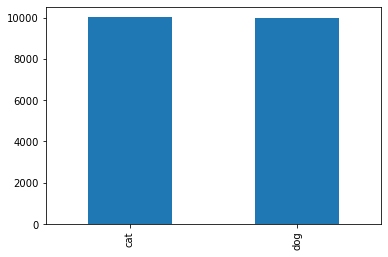

In [42]:
train['category'].value_counts().plot.bar()

<AxesSubplot:>

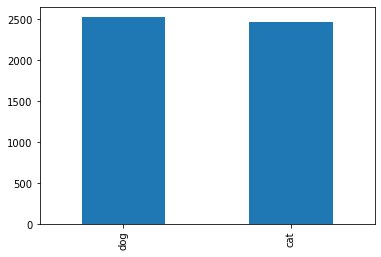

In [43]:
validation['category'].value_counts().plot.bar()

In [44]:
total_train = train.shape[0]
total_validation = validation.shape[0]
batch_size=15

## Training Generator

In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [47]:
train_generator = train_datagen.flow_from_dataframe(
    train, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Generator

In [48]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [50]:
example_df = train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


## Check the Generator

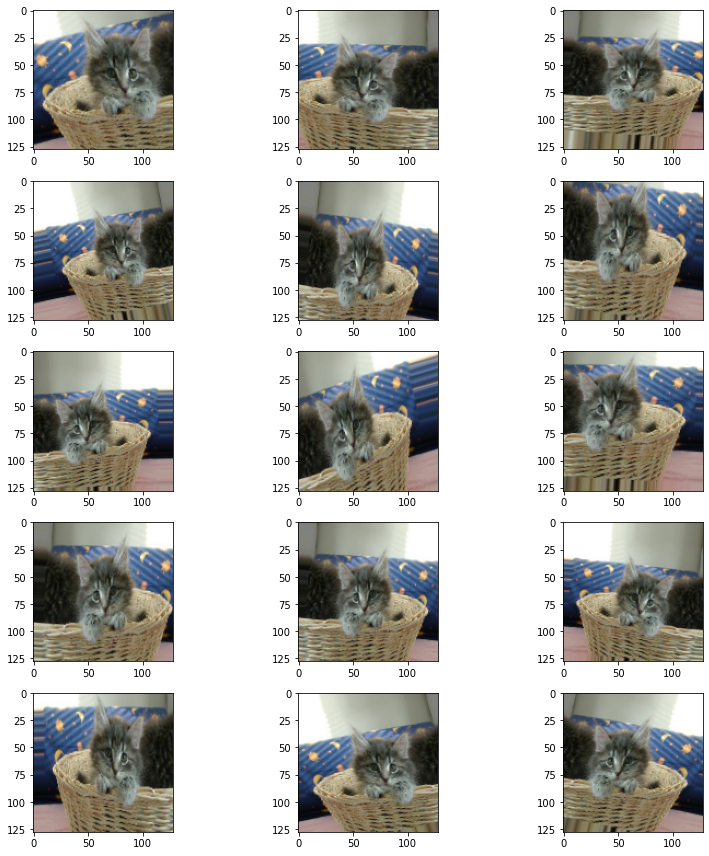

In [51]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Modeling

In [ ]:
epochs = 20

In [54]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - 2641s 2s/step - loss: 0.7418 - accuracy: 0.6376 - val_loss: 0.6858 - val_accuracy: 0.6733 - lr: 0.0010
Epoch 2/20
1333/1333 [==============================] - 2264s 2s/step - loss: 0.5469 - accuracy: 0.7294 - val_loss: 0.7398 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 3/20
1333/1333 [==============================] - 987s 741ms/step - loss: 0.4975 - accuracy: 0.7629 - val_loss: 0.4867 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 4/20
1333/1333 [==============================] - 8491s 6s/step - loss: 0.4693 - accuracy: 0.7832 - val_loss: 0.4239 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 5/20
1333/1333 [==============================] - 5202s 4s/step - loss: 0.4452 - accuracy: 0.7946 - val_loss: 0.4015 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 6/20
1333/1333 [==============================] - 6089s 5s/step - loss: 0.4237 - accuracy: 0.8098 - val_loss: 0.3716 - val_accuracy: 0.8430 - lr: 0.0010
Epoch 7/20
1333/1333 [======================

In [55]:
model.save_weights('knn_model.h5')

## Training and Validation Visualization

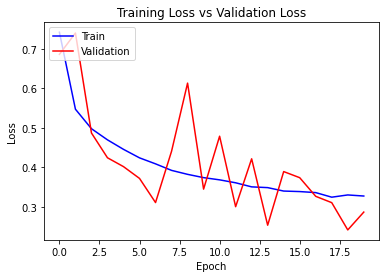

In [56]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.xticks(np.arange(1, epochs, 1))
#plt.yticks(np.arange(0, 1, 0.1))

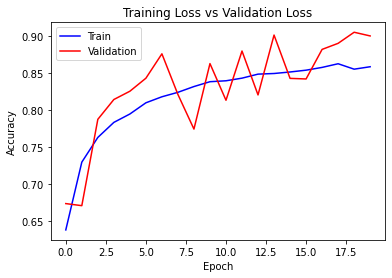

In [60]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing

Testing data

In [119]:
test_filenames = os.listdir("data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [120]:
test_df.head()

filename
0  9733.jpg
1    63.jpg
2  6400.jpg
3   823.jpg
4  4217.jpg

Testing Generator:

In [65]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_Size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [70]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [132]:
test_df['category'] = np.argmax(predict, axis=-1)

In [133]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

## Result

<AxesSubplot:>

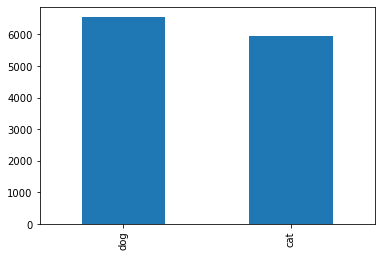

In [134]:
test_df['category'].value_counts().plot.bar()

In [135]:
test_df

filename category
0      9733.jpg      cat
1        63.jpg      cat
2      6400.jpg      dog
3       823.jpg      dog
4      4217.jpg      cat
...         ...      ...
12495  3561.jpg      cat
12496  8434.jpg      dog
12497  7707.jpg      cat
12498  6419.jpg      cat
12499  1376.jpg      dog

[12500 rows x 2 columns]

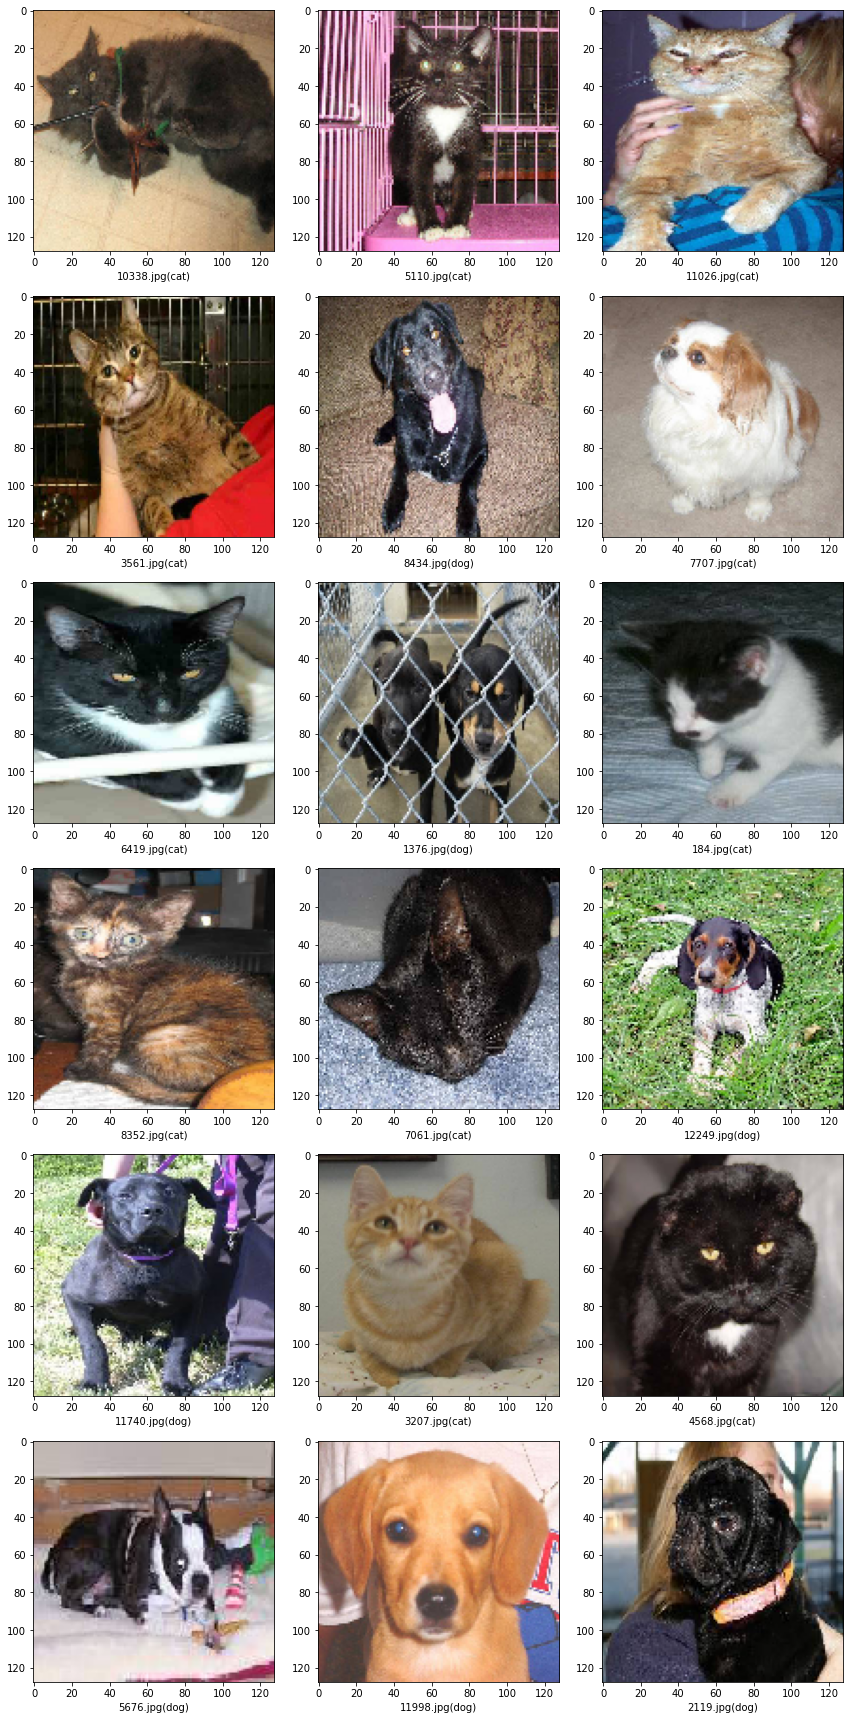

In [136]:
res = test_df.tail(18)
#res.head()
plt.figure(figsize=(12, 24))
for index, row in res.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index%18 +1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()

## Test my own data

In [123]:
my_cat = os.listdir("data/my_cat")
my_df = pd.DataFrame({
    'filename': my_cat
})
nb_samples = my_df.shape[0]

In [124]:
my_df

filename
0  Abbacchio_8.jpg
1     Cheems_1.jpg
2  Abbacchio_2.jpg
3  Abbacchio_3.jpg
4  Abbacchio_1.jpg
5  Abbacchio_4.jpg
6  Abbacchio_5.jpg
7  Abbacchio_7.jpg
8  Abbacchio_6.jpg

In [125]:
my_gen = ImageDataGenerator(rescale=1./255)
my_generator = my_gen.flow_from_dataframe(
    my_df, 
    "data/my_cat/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_Size,
    batch_size=batch_size,
    shuffle=False
)

Found 9 validated image filenames.


In [126]:
predict_mycat = model.predict_generator(my_generator, steps=np.ceil(nb_samples/batch_size))

In [127]:
my_df['category'] = np.argmax(predict_mycat, axis=-1)

In [129]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
my_df['category'] = my_df['category'].replace(label_map)

In [130]:
my_df

filename category
0  Abbacchio_8.jpg      cat
1     Cheems_1.jpg      dog
2  Abbacchio_2.jpg      cat
3  Abbacchio_3.jpg      cat
4  Abbacchio_1.jpg      cat
5  Abbacchio_4.jpg      cat
6  Abbacchio_5.jpg      cat
7  Abbacchio_7.jpg      cat
8  Abbacchio_6.jpg      cat

NameError: name 'savefig' is not defined

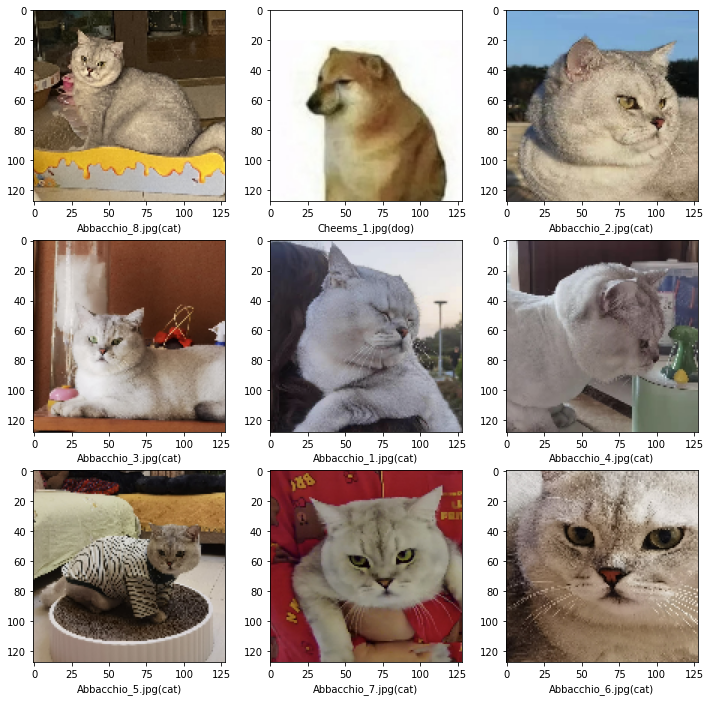

In [141]:
res = my_df
plt.figure(figsize=(12, 12))
for index, row in res.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/my_cat/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.savefig("my_cat_classification.png")